In [1]:
from grid_search_tools import GSTools
from distance_method import DistanceStrategy, Metrics
from pair_selector import *

import backtrader as bt
import backtrader.feeds as btfeeds
import pandas as pd
import warnings
import glob
import os
import uuid
import itertools
import json

%load_ext autoreload
%autoreload 2

### Don't touch this

In [2]:
class PandasData(bt.feed.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        ('datetime', 0),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

### Set your params

In [15]:
# INPUT PARAMETERS

DIR = "../ib-data/nyse-daily-tech/"

BT_START_DT = '2016-01-04'
TEST_PERIOD = 252

PAIR_FORMATION_LEN = 60

# top PCT percentage of the pairs with lowest distance will be backtested
PCT = 0.005

# STRATEGY PARAMETERS
LOOKBACK_VALUE = [25, 30, 35, 40]
ENTER_THRESHOLD_SIZE = [2, 3]
EXIT_THRESHOLD_SIZE = [0.5]
LOSS_LIMIT = [-0.01, -0.02]
MAX_LOOKBACK = max(LOOKBACK_VALUE)

# Where to save the ouputs
DST_DIR = "../backtest-results/distance/test4/"

### Save these configurations ...

In [16]:
CONFIG = {
    'DIR': DIR,
    'BT_START_DT': BT_START_DT,
    'TEST_PERIOD': TEST_PERIOD,
    'PAIR_FORMATION_LEN': PAIR_FORMATION_LEN,
    'PCT': PCT,
    'LOOKBACK_VALUE': LOOKBACK_VALUE,
    'ENTER_THRESHOLD_SIZE': ENTER_THRESHOLD_SIZE,
    'EXIT_THRESHOLD_SIZE': EXIT_THRESHOLD_SIZE,
    'LOSS_LIMIT': LOSS_LIMIT,
    'MAX_LOOKBACK': MAX_LOOKBACK,
    'DST_DIR': DST_DIR,
}

# create json string
CONFIG_JSON_STR = json.dumps(CONFIG)

# create directory if neccessary
if not os.path.exists(DST_DIR):
    os.makedirs(DST_DIR)
    
# save json string to a file
with open(DST_DIR + 'config.json', 'w') as outfile:
    json.dump(CONFIG_JSON_STR, outfile)

### Data wrangling :)

In [17]:
print("---------------------------------------------------------------------")

###################################################################################################################
# Load data
data = GSTools.load_csv_files(DIR)
dt_idx = GSTools.get_trading_dates(data)

print("Initial number of datafeeds: " + str(len(dt_idx)) + ".")

###################################################################################################################
# get position of intended start date of backtest
bt_start_idx = dt_idx.get_loc(BT_START_DT)
size = PAIR_FORMATION_LEN + MAX_LOOKBACK + (len(dt_idx) - bt_start_idx)

print("To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = " + str(size) + ".")

# get datafeeds which fulfill size requirement
data = GSTools.cut_datafeeds(data, size=size)

print("After cutting datafeeds, " + str(len(data.keys())) + " datafeeds remaining.")

###################################################################################################################
# just to be safe, sync the start end dates of the dataframes
data, start_dt, end_dt = GSTools.sync_start_end(data)
dt_idx = GSTools.get_trading_dates(data)

print("Backtest start date: " + str(dt_idx[PAIR_FORMATION_LEN + MAX_LOOKBACK]))
print("Backtest end date: " + str(dt_idx[PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD - 1]))

###################################################################################################################
# get aggregated close prices
close_df = GSTools.get_aggregated(data, col='close')

if close_df.isnull().values.any():
    warnings.warn("There are null values in the aggregated close price df.")
else:
    print("No null values detected in aggregated close price df.")

###################################################################################################################
# total number of stocks remaining
N = len(data.keys())

# number of pairs of interest
K = int(PCT * N * (N-1) / 2)

print("From " + str(int(N * (N-1) / 2)) + " pairs, pick the top " + str(K) + " pairs in terms of MSE score.")

###################################################################################################################
# pair selection
good_pairs = select_pairs_for_all_combin(train_df=close_df[0:PAIR_FORMATION_LEN], test_df=None,
        config={'n': K, 'score_function': distance_score, 'series_transform': distance_transform}, plot=False)

print("---------------------------------------------------------------------")

---------------------------------------------------------------------
Initial number of datafeeds: 2517.
To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = 857.
After cutting datafeeds, 122 datafeeds remaining.
Backtest start date: 2016-01-04 00:00:00
Backtest end date: 2016-12-30 00:00:00
No null values detected in aggregated close price df.
From 7381 pairs, pick the top 36 pairs in terms of MSE score.
---------------------------------------------------------------------


### OK let's do grid search!

In [18]:
# combinations of parameters
param_combinations = list(itertools.product(LOOKBACK_VALUE, ENTER_THRESHOLD_SIZE, EXIT_THRESHOLD_SIZE, LOSS_LIMIT))

# list to store MACRO results
macro_results = []

for i, params in enumerate(param_combinations, 1):
    # set params
    print("Running " + str(i) + "/" + str(len(param_combinations)))
    print("Backtesting all pairs using parameters " + str(params))
    # list to store MICRO results
    results = []

    for pair in good_pairs:
        # get names of both stock
        stk0, stk1 = pair

        # get data of both stock
        stk0_df, stk1_df = data[stk0], data[stk1]
        stk0_df_test = stk0_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
        stk1_df_test = stk1_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
        
        # Create a cerebro
        cerebro = bt.Cerebro()

        # Create data feeds
        data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
        data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

        # add data feeds to cerebro
        cerebro.adddata(data0)
        cerebro.adddata(data1)

        # Add the strategy
        cerebro.addstrategy(DistanceStrategy, 
                            lookback=params[0],
                            max_lookback=MAX_LOOKBACK,
                            enter_threshold_size=params[1], 
                            exit_threshold_size=params[2], 
                            loss_limit=params[3])

        # Add analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
        cerebro.addanalyzer(Metrics, 
                            lookback=MAX_LOOKBACK, 
                            _name='metrics')

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcash(1000000)

        # And run it
        strat = cerebro.run()

        # get MICRO metrics
        sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
        returnstd = strat[0].analyzers.metrics.returns_std()
        startcash = cerebro.getbroker().startingcash
        endcash = cerebro.getbroker().getvalue()
        profit = (endcash - startcash) / startcash
        
        results.append((stk0 + "-" + stk1, sharperatio, profit, returnstd))
    
    # convert to dataframe
    results_df = pd.DataFrame(results)
    results_df.columns = ['pair', 'sharpe_ratio', 'overall_return', 'returns_std']
    
    # save as csv
    uuid_str = str(uuid.uuid4())
    path = DST_DIR + str(uuid_str) + ".csv" 
    results_df.to_csv(path_or_buf=path, index=False)
    
    # calculate MACRO attributes
    avg_sharpe_ratio = results_df['sharpe_ratio'].mean()
    median_sharpe_ratio = results_df['sharpe_ratio'].median()
    
    avg_overall_return = results_df['overall_return'].mean()
    median_overall_return = results_df['overall_return'].median()
    overall_return_std = results_df['overall_return'].std()

    
    macro_results.append((params[0], 
                          params[1], 
                          params[2], 
                          params[3],
                          avg_sharpe_ratio,
                          median_sharpe_ratio,
                          avg_overall_return,
                          median_overall_return,
                          overall_return_std,
                          uuid_str
                         ))
    
    # nextline
    print("")

macro_results_df = pd.DataFrame(macro_results)
macro_results_df.columns = ['lookback', 
                            'enter_threshold_size', 
                            'exit_threshold_size',
                            'loss_limit', 
                            'avg_sharpe_ratio', 
                            'median_sharpe_ratio',
                            'avg_overall_return', 
                            'median_overall_return',
                            'overall_return_std',
                            'uuid']
macro_results_df.to_csv(DST_DIR + 'summary.csv', index=False)

Running 1/16
Backtesting all pairs using parameters (25, 2, 0.5, -0.01)
------------------------------------
Running 2/16
Backtesting all pairs using parameters (25, 2, 0.5, -0.02)
------------------------------------
Running 3/16
Backtesting all pairs using parameters (25, 3, 0.5, -0.01)
------------------------------------
Running 4/16
Backtesting all pairs using parameters (25, 3, 0.5, -0.02)
------------------------------------
Running 5/16
Backtesting all pairs using parameters (30, 2, 0.5, -0.01)
------------------------------------
Running 6/16
Backtesting all pairs using parameters (30, 2, 0.5, -0.02)
------------------------------------
Running 7/16
Backtesting all pairs using parameters (30, 3, 0.5, -0.01)
------------------------------------
Running 8/16
Backtesting all pairs using parameters (30, 3, 0.5, -0.02)
------------------------------------
Running 9/16
Backtesting all pairs using parameters (35, 2, 0.5, -0.01)
------------------------------------
Running 10/16
Backt

In [19]:
macro_results_df = pd.read_csv(DST_DIR + "summary.csv")
macro_results_df

,lookback,enter_threshold_size,exit_threshold_size,loss_limit,avg_sharpe_ratio,median_sharpe_ratio,avg_overall_return,median_overall_return,overall_return_std,uuid
0,25,2,0.5,-0.01,NaN,NaN,0.028159,0.010831,0.179547,9337b73b-2990-4b04-aff7-cb013293d0f1
1,25,2,0.5,-0.02,NaN,NaN,0.036311,0.010580,0.202804,2da15ede-3148-4fe3-b174-656cf55257e5
2,25,3,0.5,-0.01,NaN,NaN,0.015045,0.000000,0.077077,1483d2ab-1d09-428d-aa27-c1e13fd1895b
3,25,3,0.5,-0.02,NaN,NaN,0.014923,0.000000,0.080166,21a45cea-93e2-4adb-82bd-e15b920bc7f3
4,30,2,0.5,-0.01,NaN,NaN,0.018368,0.016723,0.185746,ee2fc53b-2bbc-4e7c-bd5f-b8f2e0234472
5,30,2,0.5,-0.02,NaN,NaN,0.027143,0.036867,0.194277,75e38ba4-69c0-4e08-9cb9-a98af77ac03c
6,30,3,0.5,-0.01,NaN,NaN,0.020538,0.000709,0.077747,90ff5863-74c8-44b8-9b62-f0f01a56ba66
7,30,3,0.5,-0.02,NaN,NaN,0.021306,0.000709,0.081987,96822c01-3eda-4f84-84a2-4f6e7eecb22a
8,35,2,0.5,-0.01,NaN,NaN,0.039021,-0.010140,0.199273,1ff83aad-e9f7-4b1a-9bbf-236affd69ac7
9,35,2,0.5,-0.02,NaN,NaN,0.047690,0.025888,0.189714,27701811-ec23-4d45-bdd5-c7371b9f9d41


In [20]:
macro_results_df[macro_results_df['avg_overall_return'] == max(macro_results_df['avg_overall_return'])]

,lookback,enter_threshold_size,exit_threshold_size,loss_limit,avg_sharpe_ratio,median_sharpe_ratio,avg_overall_return,median_overall_return,overall_return_std,uuid
9,35,2,0.5,-0.02,NaN,NaN,0.04769,0.025888,0.189714,27701811-ec23-4d45-bdd5-c7371b9f9d41


### Now, if you're interested to look into one specific pair .. 

In [25]:
# set your params
_STK0 = 'KAI'
_STK1 = 'TBI'
_LOOKBACK = 30
_ENTER_THRESHOLD_SIZE = 2
_EXIT_THRESHOLD_SIZE = 0.5
_LOSS_LIMIT = -0.01

In [26]:
def backtest_single_pair(_stk0, _stk1, _lookback, _enter_threshold_size, _exit_threshold_size, _loss_limit):
    # get data of both stock
    stk0_df, stk1_df = data[_stk0], data[_stk1]
    stk0_df_test = stk0_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
    stk1_df_test = stk1_df[PAIR_FORMATION_LEN + MAX_LOOKBACK : PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]

    # Create a cerebro
    cerebro = bt.Cerebro()

    # Create data feeds
    data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
    data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

    # add data feeds to cerebro
    cerebro.adddata(data0)
    cerebro.adddata(data1)

    # Add the strategy
    cerebro.addstrategy(DistanceStrategy, 
                        lookback=_lookback,
                        max_lookback=MAX_LOOKBACK,
                        enter_threshold_size=_enter_threshold_size, 
                        exit_threshold_size=_exit_threshold_size, 
                        loss_limit=_loss_limit,
                        print_bar=False,
                        print_msg=True,
                        print_transaction=True,
                       )

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(Metrics, 
                        lookback=MAX_LOOKBACK, 
                        _name='metrics')

    # Add the commission - only stocks like a for each operation
    cerebro.broker.setcash(1000000)

    # And run it
    strat = cerebro.run()
    
    return (cerebro, strat)

In [27]:
cerebro, strat = backtest_single_pair(_STK0, _STK1, _LOOKBACK, _ENTER_THRESHOLD_SIZE, _EXIT_THRESHOLD_SIZE, _LOSS_LIMIT)

2016-03-11T00:00:00, SELL COMPLETE, 41.91
2016-03-11T00:00:00, BUY COMPLETE, 23.55
2016-04-22T00:00:00, BUY COMPLETE, 46.08
2016-04-22T00:00:00, SELL COMPLETE, 20.84
2016-04-25T00:00:00, SELL COMPLETE, 45.02
2016-04-25T00:00:00, BUY COMPLETE, 21.01
2016-04-29T00:00:00, BUY COMPLETE, 47.34
2016-04-29T00:00:00, SELL COMPLETE, 20.41
2016-05-02T00:00:00, SELL COMPLETE, 47.44
2016-05-02T00:00:00, BUY COMPLETE, 18.82
2016-05-20T00:00:00, BUY COMPLETE, 48.11
2016-05-20T00:00:00, SELL COMPLETE, 18.07
2016-06-24T00:00:00, SELL COMPLETE, 53.01
2016-06-24T00:00:00, BUY COMPLETE, 18.48
2016-06-27T00:00:00, BUY COMPLETE, 50.26
2016-06-27T00:00:00, SELL COMPLETE, 18.09
2016-06-30T00:00:00, SELL COMPLETE, 51.12
2016-06-30T00:00:00, BUY COMPLETE, 18.49
2016-07-22T00:00:00, BUY COMPLETE, 53.66
2016-07-22T00:00:00, SELL COMPLETE, 22.82
2016-08-11T00:00:00, BUY COMPLETE, 52.10
2016-08-11T00:00:00, SELL COMPLETE, 22.14
2016-08-12T00:00:00, SELL COMPLETE, 51.91
2016-08-12T00:00:00, BUY COMPLETE, 22.41
2016

C:\Users\emara\Anaconda3\envs\traders_nlp\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


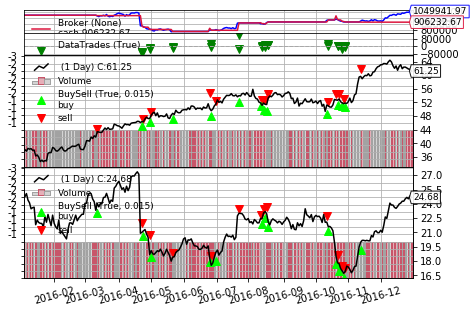

[[<matplotlib.figure.Figure at 0x1be076f44a8>]]

In [28]:
cerebro.plot()

### Sharpe ratio, profit

In [29]:
sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
startcash = cerebro.getbroker().startingcash
endcash = cerebro.getbroker().getvalue()
profit = (endcash - startcash) / startcash

print(sharperatio)
print(profit)

None
0.04994197491452028


### Trade statistics

In [30]:
n_trades = strat[0].analyzers.metrics.n_trades
n_resolved_trades = strat[0].analyzers.metrics.n_resolved_trades
n_unresolved_trades = strat[0].analyzers.metrics.n_unresolved_trades
avg_holding_period = strat[0].analyzers.metrics.avg_holding_period
len_unresolved_trade= strat[0].analyzers.metrics.len_unresolved_trade

returns = strat[0].analyzers.metrics.returns
pv = strat[0].analyzers.metrics.pv

print(n_trades, n_resolved_trades, n_unresolved_trades, avg_holding_period, len_unresolved_trade)

13 12 1 5.916666666666667 35


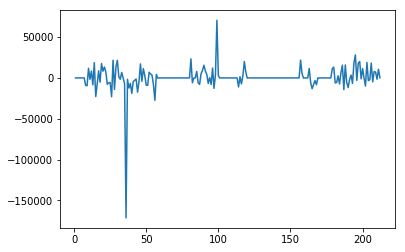

In [31]:
plt.plot(returns)
plt.show()

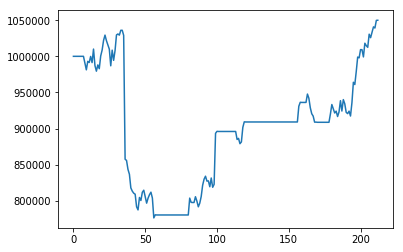

In [32]:
plt.plot(pv)
plt.show()